In [30]:
# !apt-get update && apt-get install -y git-all

In [31]:
# !git init && dvc init

In [32]:
# import git 
# g = git.Git(os.getcwd()) 
# hexshas = g.log('--pretty=%H','--follow','--',"Y_data.npy.dvc").split('\n') 

In [33]:
# hexshas

In [34]:
# !git config --global user.email "danyail@mail.com"
# !git config --global user.name "danzz006"

In [35]:
from sklearn.datasets import make_classification
from sklearn.datasets import make_circles
import numpy as np
import os
import matplotlib.pyplot as plt
from pathlib import Path
from PIL import Image
import mlflow

In [36]:
'''When creating new experiment'''
# experiment_id = mlflow.create_experiment(
#     "Linear classifier", 
#     artifact_location=Path.cwd().joinpath("./mlruns").as_uri(),
#     tags={"version":"v1", "priority":"P1"}
# )

'When creating new experiment'

In [37]:
mlflow.set_tracking_uri("sqlite:///mlruns/mlruns.db")

In [38]:
experiment = mlflow.set_experiment("Linear classifier")

In [39]:
x,Y = make_classification(n_features=2,n_classes=2,n_samples=100,n_redundant=0,n_clusters_per_class=1)

In [40]:
with open("X_data.npy", "wb") as fs_x:
    np.save(fs_x, x)

with open("Y_data.npy", "wb") as fs_y:
    np.save(fs_y, Y)

In [41]:
!dvc add X_data.npy Y_data.npy
!git add X_data.npy.dvc Y_data.npy.dvc .gitignore
!git commit -m "version 1.0.0 of data"
!git tag -a "dvc1" -m "save data for dvc first time"
# !git log


To track the changes with git, run:

	git add X_data.npy.dvc Y_data.npy.dvc

To enable auto staging, run:

	dvc config core.autostage true
[master 0aecea1] version 1.0.0 of data
 2 files changed, 4 insertions(+), 4 deletions(-)


In [42]:
class LinearClassifier:
    def __init__(self, mlflow_exp_id):
        self.mlflow_exp_id = mlflow_exp_id
        # pass
    def sigmoid(self,z):
        return 1.0/(1. + np.exp(-z))

    def loss(self,y,y_ht):
        loss =  -np.mean( y*(np.log(y_ht)) - (1-y)*np.log(1-y_ht) )
        return loss

    def gradient(self,x,y,y_ht):
        m = x.shape[0]
        dw = (1/m)*np.dot(x.T,(y_ht-y)) #wrt w
        db = (1/m)*np.sum((y_ht-y)) # wrt bias
        return dw,db 

    def plot_dec_boundry(self,x,w,b,y,debug, save):
        x1 = [min(x[:,0]), max(x[:,0])]
        m = -w[0]/w[1]
        c = -b/w[1]
        x2 = m*x1 + c
        plt.plot(x[:,0][y==0], x[:,1][y==0],'r^')
        plt.plot(x[:,0][y==1], x[:,1][y==1],'bs')
        plt.plot(x1,x2,'y-')
        if debug:
            plt.show()
        if save:
            plt.savefig("tmp.png")

    def normalize(self,x):
        m,n = x.shape   #m : trg exmple, n: features
        for i in range(n):
            x = (x - x.mean(axis=0))/x.std(axis=0)
        return x    

    def fit(self, x,y,bs,epochs,lr):
        m,n = x.shape
        w = np.zeros((n,1))  ## or random ?
        b = 0
        y_ = y
        y = y.reshape(m,1)
        x = self.normalize(x)

        losses = []
        params = {"learning_rate": lr, "batch_size": bs, "epochs": epochs}
        with mlflow.start_run(experiment_id=self.mlflow_exp_id, description="Linear classifier for data points", run_name=f"LC-{epochs}-{bs}-{lr}") as run:
            mlflow.log_params(params)        
            for epoch in range(epochs):
                for i in range((m-1)//bs+1):
                    start_i = i*bs
                    end_i = start_i + bs
                    xb = x[start_i:end_i]
                    yb = y[start_i:end_i]

                    y_ht = self.sigmoid(np.dot(xb,w)+b)

                    dw,db = self.gradient(xb,yb,y_ht)

                    w -=lr*dw
                    b -=lr*db

                l = self.loss(y,self.sigmoid(np.dot(x,w)+b))
                mlflow.log_metric("loss", l)
                losses.append(l)

            y_ht = self.predict(x, w, b)
            acc = self.accuracy(y, y_ht)
            mlflow.log_metric("Acc", acc)
            self.plot_dec_boundry(x,w,b,y_,False, True)
            mlflow.log_image(Image.open("tmp.png"), "dec_boundry.png")
            
        return w,b,losses

    def step_func(self,z):
        return 1.0 if (z > 0) else 0.0

       

    def predict(self,x,w,b):

        x = self.normalize(x)
        preds = self.sigmoid((np.dot(x,w)+b))
        pred_class = []

        pred_class = [1 if i>0.5 else 0 for i in preds]

        return np.array(pred_class)
    
    def accuracy(self,y, y_ht):
        accuracy = np.sum(y == y_ht) / len(y)
        return accuracy


In [43]:
p = LinearClassifier(experiment.experiment_id)

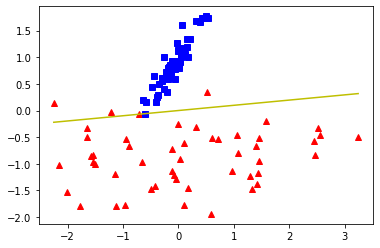

In [44]:
w,b,loss = p.fit(x,Y,bs=10,epochs=40,lr=0.001)

In [45]:
class_pred = p.predict(x,w,b)

In [46]:
print('Accuracy= ',p.accuracy(Y,class_pred) * 100,'%')

Accuracy=  96.0 %


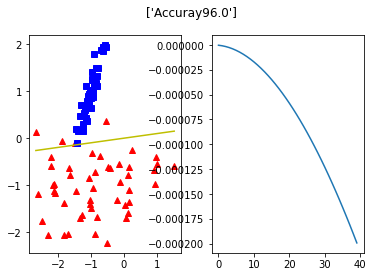

In [47]:
plt.subplot(1,2,1)
p.plot_dec_boundry(x,w,b,Y,0, False)
plt.subplot(1,2,2)
plt.plot(loss)
plt.suptitle(['Accuray' + str(p.accuracy(Y,class_pred) * 100)])
plt.show()

In [48]:
x,Y = make_classification(n_features=2,n_classes=2,n_samples=200,n_redundant=0,n_clusters_per_class=1)

In [49]:
with open("X_data.npy", "wb") as fs_x:
    np.save(fs_x, x)

with open("Y_data.npy", "wb") as fs_y:
    np.save(fs_y, Y)

In [50]:
!dvc add X_data.npy Y_data.npy
!git add X_data.npy.dvc Y_data.npy.dvc .gitignore
!git commit -m "version 1.0.1 of data with increased samples 100 -> 200"
!git tag -a "dvc2" -m "save data for dvc second time"

# !git log


To track the changes with git, run:

	git add Y_data.npy.dvc X_data.npy.dvc

To enable auto staging, run:

	dvc config core.autostage true
[master 9a4aec9] version 1.0.1 of data with increased samples 100 -> 200
 2 files changed, 4 insertions(+), 4 deletions(-)


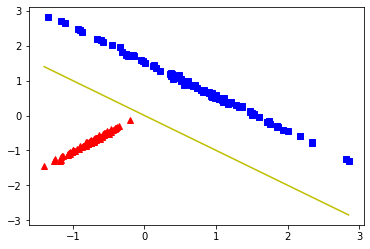

In [51]:
w1,b1,loss1 = p.fit(x,Y,bs=10,epochs=40,lr=0.001)

In [52]:
class_pred = p.predict(x,w1,b1)
print('Accuracy= ',p.accuracy(Y,class_pred) * 100,'%')

Accuracy=  100.0 %


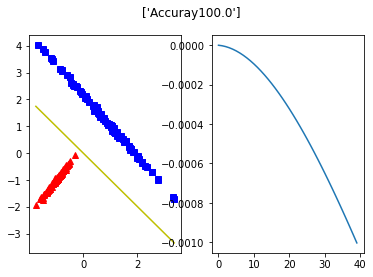

In [53]:
plt.subplot(1,2,1)
p.plot_dec_boundry(x,w1,b1,Y,0, False)
plt.subplot(1,2,2)
plt.plot(loss1)
plt.suptitle(['Accuray' + str(p.accuracy(Y,class_pred) * 100)])
plt.show()

## Reverting back data

In [54]:
# !git log
!git fetch --all --tags

Fetching origin


In [55]:
!git checkout dvc1 #059ce205b4be748d31fab6b18aa4d5028ebc48c5
!dvc checkout

error: pathspec '#059ce205b4be748d31fab6b18aa4d5028ebc48c5' did not match any file(s) known to git
ERROR: Checkout failed for following targets:
C:\flask_app_docker\DL_codes\metrics.csv
C:\flask_app_docker\DL_codes\model.h5
C:\flask_app_docker\DL_codes\data
Is your cache up to date?
<https://error.dvc.org/missing-files>


In [56]:
with open("X_data.npy", "rb") as fs_x:
    X = np.load(fs_x)
    
with open("Y_data.npy", "rb") as fs_y:
    Y = np.load(fs_y)

In [57]:
X.shape, Y.shape

((200, 2), (200,))

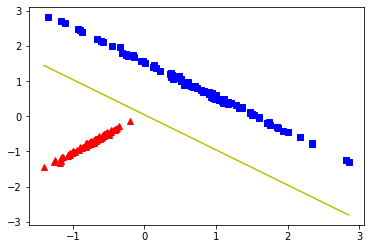

In [58]:
w1,b1,loss1 = p.fit(X,Y,bs=10,epochs=100,lr=0.01)

In [59]:
class_pred = p.predict(x,w1,b1)
print('Accuracy= ',p.accuracy(Y,class_pred) * 100,'%')

Accuracy=  100.0 %
